In [1]:
from Bio import SeqIO
from Bio import Phylo
import matplotlib.pyplot as plt
from Bio import SeqIO
import pandas as pd
from itertools import product
import re
import numpy as np
from scipy import stats
import os
import pickle

In [ ]:
def root_tree_with_first_sequence(tree, root_sequence):
    """
    Roots the tree file with the provided root sequence.

    Parameters:
        - tree: The tree object to be rooted.
        - root_sequence (str): The identifier of the sequence to be used as the root.

    Returns:
        - rooted_tree_file (str): The path to the rooted tree file.
    """
    # Root the tree file with the outgroup
    rooted_tree_file = tree.root_with_outgroup(root_sequence)

    return rooted_tree_file



In [ ]:
def get_reconstructed_ancestral_sequences(ancestral_state_file_path):
    """
    Reconstructs ancestral node sequences from the ancestral state file.
    
    Parameters:
        - ancestral_state_file_path (str): The path to the ancestral state file.
    
    Returns:
        - dict: A dictionary containing the reconstructed ancestral sequences, where the keys are the ancestral node ids and the values are the reconstructed sequences.
    """
    # Read the ancestral state file
    ancestral_states = pd.read_csv(ancestral_state_file_path, sep='\t', skiprows=8)

    # Concatenate the ancestral states for all the positions for a given ancestral node to reconstruct the sequence for that node
    ancestral_sequences = {}
    for node, group in ancestral_states.groupby('Node'):
        sequence = ''.join(group['State'])
        ancestral_sequences[node] = sequence
    
    return ancestral_sequences

In [ ]:
#Function to compute the trinucleotide frequency of a sequence to be used in normalization step while computing the trinucleotide mutation rate
def get_kmer_frequency(sequence, k):
    """
    Calculate the frequency of k-mers in a given sequence.

    Parameters:
        - sequence (str): The input RNA sequence.
        - k (int): The length of the k-mer.

    Returns:
        - kmers_frequency_dict: A dictionary containing all possible k-mers as keys and their frequencies in the input sequence as values.
    """
    # Remove gaps from the sequence if any
    sequence = sequence.replace("-", "")
    #Total number of kmers in the sequence
    total_kmers = len(sequence) - k + 1

    # Declare and Initialize the dictionary to store the kmer frequency by assigning all possible k-mers with frequency 0
    nucleotides = ["C", "T", "G", "A"]
    kmers_frequency_dict = {''.join(combo): 0 for combo in product(nucleotides, repeat=k)}

    # Iterate through the sequence to find all k-mers
    for i in range(total_kmers):
        kmer = sequence[i:i + k]  # Extract the k-mer
        # Check if the k-mer consists only of A, T, G, or C and not any other characters
        if set(kmer).issubset(set(nucleotides)):
            # Increment the frequency of this k-mer in the kmer_frequency dictionary
            kmers_frequency_dict[kmer] += 1  
    # Return the kmer dictionary
    return kmers_frequency_dict

In [ ]:
def find_mutations_wrt_ancestral_sequence(ancestor_seq, sample_seq):
    """
    To compute the mutations by comparing each sequence against its nearest reconstructed ancestral sequence

    Parameters:
        - ancestor_seq (str): The ancestor sequence.
        - sample_seq (str): The sample sequence.

    Returns:
        - mutations: A list of mutations, where each mutation is represented as a list containing the mutation, the trinucleotide context, and the trinucleotide frequency
    """
    # Initialize the list to store the mutations
    mutations = []
    # Get the trinucleotide mutation frequencies in the ancestor sequence
    trinucleotide_mutation_frequency = get_kmer_frequency(ancestor_seq, 3)
    # Iterate through each position and bases in the two sequences
    for i, (a, b) in enumerate(zip(ancestor_seq, sample_seq)):
        # If the base is different between the ancestor and sample sequences 
        if a != b:
            #position of the mutation in the alignment is index + 1
            position = i + 1  
            # Extract the trinucleotide context of the mutation
            trinucleotide = str(ancestor_seq[position-2:position+1]).upper()  
            # Base in the ancestor sequence
            ref_base = a.upper()
            # Base in the sample sequence
            sample_base = b.upper()
            # We ignore those mutations at the starting or end position of the alignment as their trinucleotide context cannot be captured
            # We also ignore those mutations in which the surrounding trinucleotide contains abnormal basses or the mutation itself contains abnormal bases
            if (
                any(base not in ["C", "T", "G", "A"] for base in trinucleotide) or
                any(base not in ["C", "T", "G", "A"] for base in [ref_base, sample_base]) or
                len(trinucleotide) != 3
            ):                
                continue
            else:
                # Record the mutation data which includes the mutation, its trinucleotide context and trinuleotide frequency 
                mutation = f"{ref_base}{position}{sample_base}".upper()
                mutations.append([mutation, trinucleotide, trinucleotide_mutation_frequency[trinucleotide]])
               
    return mutations


In [ ]:
def find_ancestral_node(tree, node_name):
    """
    To find the nearest ancestral node to a particular node in the tree

    Parameters:
        - tree: The phylogenetic tree to search in.
        - node_name: The name of the node for which we wish to find the nearest ancestor.

    Returns:
        - ancestral_node: The ancestral node if found, None otherwise.
    """
    # Search the target node in the tree
    target_node = next((clade for clade in tree.find_clades() if str(clade.name).split("/")[0] == node_name), None)
    if target_node is None:
        print(f"Node '{node_name}' not found.")
        return None

    # Traverse the tree to find the nearest ancestral node to the target node
    ancestral_node = None
    for clade in tree.find_clades():
        if target_node in clade:
            ancestral_node = clade
            break
    
    #return nearest ancestral node
    return ancestral_node



In [ ]:

def get_mutation_data_for_internal_nodes(ancestral_sequences, msa_file_path, tree):
    """ 
    To compute the mutations for the internal nodes of the tree

    Args:
        ancestral_sequences (dict): Dictionary of reconstructed ancestral sequences.
        msa_file_path (str): The path to the mutiple sequence alignment file.
        tree: The phylogenetic tree.

    Returns:
         - denovo_mutations: A dictionary mapping each internal node to its denovo mutations.
         - ancestral_mutations: A dictionary mapping each internal node to its ancestral mutations.
         - ancestral_node_data: A dictionary mapping each internal node to its nearest ancestral node.

    """
    # Initialize the dictionaries to store the mutation data
    denovo_mutations = {}
    ancestral_mutations = {}
    ancestral_node_data = {}

    # Sort the ancestral nodes based on their node number
    ancestral_nodes = list(ancestral_sequences.keys())
    ancestral_nodes = sorted(ancestral_nodes, key=lambda node: int(re.search(r'\d+', node).group()))

    for node in ancestral_nodes:
        # If it is the initial node, then the reference sequence is used as the ancestral sequence
        if node == "Node1":
            reference_record = next(SeqIO.parse(msa_file_path, "fasta"), None)
            reference_id = reference_record.id
            reference_seq = str(reference_record.seq).upper()
            denovo_mutations[node] = find_mutations_wrt_ancestral_sequence(reference_seq, ancestral_sequences[node])
            ancestral_mutations[node] = []
            ancestral_node_data["Node1"] = reference_id
        # If it is not the initial node, then we find the nearest ancestor and compute the mutations against it
        else:
            ancestral_node = find_ancestral_node(tree, node)
            denovo_mutations[node] = find_mutations_wrt_ancestral_sequence(
                ancestral_sequences[str(ancestral_node).split("/")[0]], ancestral_sequences[node]
            )
            ancestral_mutations[node] = (
                denovo_mutations[str(ancestral_node).split("/")[0]]
                + ancestral_mutations[str(ancestral_node).split("/")[0]]
            )
            ancestral_node_data[node] = ancestral_node

    return denovo_mutations, ancestral_mutations, ancestral_node_data


In [ ]:

def get_mutation_data_for_leaf_nodes(alignment_file, ancestral_sequences, denovo_mutations, ancestral_mutations, tree, ancestral_node_data):
    """
    To compute the mutations for the leaf nodes of the tree
    
    Parameters:
        - alignment_file (str): Path to the multiple sequence alignment file .
        - ancestral_sequences (dict): Dictionary of reconstructed ancestral sequences.
        - denovo_mutations (dict): Dictionary to store denovo mutations. 
        - ancestral_mutations (dict): Dictionary to store ancestral mutations. 
        - tree: the Phylogenetic tree object.
        - ancestral_node_data (dict): Dictionary to store ancestral node data.

    Returns:
        - denovo_mutations (dict): Updated dictionary of denovo mutations.
        - ancestral_mutations (dict): Updated dictionary of ancestral mutations.
        - ancestral_node_data (dict): Updated dictionary of ancestral node data for each leaf node.
    """
    # Get the leaf node names from the alignment file    
    leaf_nodes = [record.id for record in SeqIO.parse(alignment_file, "fasta")]
    #As the first leaf node is the reference sequence, we need to handle it separately
    denovo_mutations[leaf_nodes[0]] = []
    ancestral_mutations[leaf_nodes[0]] = []
    #Remove the reference sequence from the leaf nodes
    leaf_nodes = leaf_nodes[1:]
    #Compute the mutations for each leaf node
    for leaf_node in leaf_nodes:
        #find its nearest ancestral node data
        ancestral_node = find_ancestral_node(tree, leaf_node)
        #store the ancestral node data for the leaf node
        ancestral_node_data[leaf_node] = ancestral_node
        #extract the sequence of this leaf node
        sequence = next((str(record.seq).upper() for record in SeqIO.parse(alignment_file, "fasta") if record.id == leaf_node), None)
        #compute the mutations against the nearest ancestral sequence
        denovo_mutations[leaf_node] = find_mutations_wrt_ancestral_sequence(
            ancestral_sequences[str(ancestral_node).split("/")[0]], 
            sequence)
        #bootstrapping during tree construction can modify the names of the nodes in the tree by including the bootstrap results, hence we need to extract only the node name from the tree
        #and use it to save mutation data for that leafnode
        ancestral_mutations[leaf_node] = denovo_mutations[str(ancestral_node).split("/")[0]] + ancestral_mutations[str(ancestral_node).split("/")[0]]
    return denovo_mutations, ancestral_mutations, ancestral_node_data



For each of the samples, we access the precomputed MSA files and the precomputed tree file. As IQTREE does not automatically root the tree with the outgroup hence we do it explicitly. Also, we use the ancestral states at each ancestral nodes of the tree to reconstruct the ancestral sequences. We then compute the de novo and ancestral mutations for each genome in each sample genome set.

In [ ]:

sample_size=4000 # Size of each sample
folder_path="../Samples/"   # Folder path to each directory contatining the sample subdirectories
outgroup_id = "NC_045512.2"  # Outgroup Sequence ID

# Iterate through each sample
for sample in os.listdir(folder_path):
    print(sample)
    # designate the path to the MSA file for this sample
    alignment_file_path = os.path.join(folder_path, sample, f"SARS-CoV-2_{sample}_{sample_size}+1_msa.fasta")
    # designate the path to the phylogenetic tree for this sample
    tree_path = os.path.join(folder_path, sample, f"{sample}.treefile")
    # read the tree file
    tree = Phylo.read(tree_path, "newick")
    # root it with the outgroup sequence
    root_tree_with_first_sequence(tree, outgroup_id)
    # we now reconstruct the ancestral sequences of the tree from the ancestral state file
    ancestral_sequences=get_reconstructed_ancestral_sequences(os.path.join(folder_path, sample, f"{sample}.state"))

    #we now compute the mutations for the internal nodes of the tree
    denovo_mutations, ancestral_mutations,ancestral_node_data=get_mutation_data_for_internal_nodes(ancestral_sequences,alignment_file_path, tree)

    #we now compute the mutations for the leaf nodes of the tree   
    denovo_mutations, ancestral_mutations,ancestral_node_data=get_mutation_data_for_leaf_nodes(alignment_file_path,ancestral_sequences, denovo_mutations, ancestral_mutations,tree,ancestral_node_data)

    # we extract the mutations for the leaf nodes(sampled genomes) of the tree and remove the outgroup sequence
    denovo_mutations_in_sampled_genomes = {key: value for key, value in denovo_mutations.items() if not key.startswith("Node")}
    denovo_mutations_in_sampled_genomes.pop(outgroup_id)
    ancestral_mutations_in_sampled_genomes = {key: value for key, value in denovo_mutations.items() if not key.startswith("Node")}
    ancestral_mutations_in_sampled_genomes.pop(outgroup_id)

    # we save these files containing the detected mutations
    def save_pickle(data, filepath):
        # Ensure the directory exists otherwise create it
        dir_path = os.path.dirname(filepath)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        try:
            with open(filepath, 'wb') as f:
                pickle.dump(data, f)
            print(f"Data successfully saved to {filepath}")
        except Exception as e:
            print(f"Error saving to {filepath}: {e}")

    # Save denovo mutations
    save_pickle(denovo_mutations_in_sampled_genomes, os.path.join(folder_path, sample, f"SARS-CoV-2_{sample}_denovo_mutations_in_sampled_genomes.pkl"))

    # Save ancestral mutations
    save_pickle(ancestral_mutations_in_sampled_genomes, os.path.join(folder_path, sample, f"SARS-CoV-2_{sample}_ancestral_mutations_in_sampled_genomes.pkl"))


Sample_1
Data successfully saved to ../Samples/Sample_1/SARS-CoV-2_Sample_1_denovo_mutations_in_sampled_genomes.pkl
Data successfully saved to ../Samples/Sample_1/SARS-CoV-2_Sample_1_ancestral_mutations_in_sampled_genomes.pkl
Sample_10
Data successfully saved to ../Samples/Sample_10/SARS-CoV-2_Sample_10_denovo_mutations_in_sampled_genomes.pkl
Data successfully saved to ../Samples/Sample_10/SARS-CoV-2_Sample_10_ancestral_mutations_in_sampled_genomes.pkl
Sample_11
Data successfully saved to ../Samples/Sample_11/SARS-CoV-2_Sample_11_denovo_mutations_in_sampled_genomes.pkl
Data successfully saved to ../Samples/Sample_11/SARS-CoV-2_Sample_11_ancestral_mutations_in_sampled_genomes.pkl
Sample_12
Data successfully saved to ../Samples/Sample_12/SARS-CoV-2_Sample_12_denovo_mutations_in_sampled_genomes.pkl
Data successfully saved to ../Samples/Sample_12/SARS-CoV-2_Sample_12_ancestral_mutations_in_sampled_genomes.pkl
Sample_13
Data successfully saved to ../Samples/Sample_13/SARS-CoV-2_Sample_13_de

In this final step, we compute the single and trinucleotide mutation rate estimates for the entire SARS-CoV-2 population and visualize these values through plotting

In [2]:
def get_trinucleotide_mutation_rates(denovo_mutations):
    """
    Computes and returns the trinucleotide mutation rates for a given sampled genomeset.

    Parameters:
        - denovo_mutations (dict): The dictionary containing the denovo mutations data for the given sampled genomeset.

    Returns: 
        - trinucleotide_mutation_rates(list): The trinucleotide mutation rates for the given sampled genomeset
    """
    # Generate all possible trinucleotide combinations
    flank_length=1 # since it is a trinucleotide which involves one bases on either side of the mutation site hence the value is set to 1
    nucleotides=["C", "T", "G", "A"]
    trinucleotide_list=['CCC', 'CCT', 'CCG', 'CCA', 'TCC', 'TCT', 'TCG', 'TCA', 'GCC', 'GCT', 'GCG', 'GCA', 'ACC', 'ACT', 'ACG', 'ACA', 'CTC', 'CTT', 'CTG', 'CTA', 'TTC', 'TTT', 'TTG', 'TTA', 'GTC', 'GTT', 'GTG', 'GTA', 'ATC', 'ATT', 'ATG', 'ATA', 'CGC', 'CGT', 'CGG', 'CGA', 'TGC', 'TGT', 'TGG', 'TGA', 'GGC', 'GGT', 'GGG', 'GGA', 'AGC', 'AGT', 'AGG', 'AGA', 'CAC', 'CAT', 'CAG', 'CAA', 'TAC', 'TAT', 'TAG', 'TAA', 'GAC', 'GAT', 'GAG', 'GAA', 'AAC', 'AAT', 'AAG', 'AAA']
        
    # Initialize the dictionary to store the mutation data for all the different mutations that have occured in a particular trinucleotide in a given genome population
    combined_mutation_data={}
    for trinucleotide in trinucleotide_list:
        combined_mutation_data[trinucleotide]={}
        for nucleotide in nucleotides:
            if(trinucleotide[flank_length]!=nucleotide):
                combined_mutation_data[trinucleotide][nucleotide]=[]
                
    # Store the mutation data for all the different mutations that have occured in a particular trinucleotide in the given genome population
    # Iterate through each genome
    for genome in denovo_mutations:
        # Iterate through each mutation data in that genome
        for mutation_in_genome in denovo_mutations[genome]:
            # Extract the trinucleotide information for the given mutation
            trinucleotide=mutation_in_genome[1]
            # Extracrt the new base after mutation
            alternate_base=mutation_in_genome[0][-1]
            # Append the mutation data to combined_mutation_data dictionary for the given trinucleotide and alternate base
            combined_mutation_data[trinucleotide][alternate_base].append(mutation_in_genome)
            
    # List to store the computed trinucleotide mutation rates for the given genome set
    trinucleotide_mutation_rates=[]

    # Each mutation type is associated with 16 trinucleotides which we sublist here
    for i in range(0,len(combined_mutation_data),16):
        sublist=list(combined_mutation_data.keys())[i:i+16]
        # Iterate through the nucleotide bases
        for new_base in ["A","C","G","T"]:
            # We iterate through each trinucleotide in the sublist
            for trinucleotide in sublist:
                # It is a mutation if the middle base in the trinucleotide is not same as the new base
                if(trinucleotide[1]!=new_base):
                    # We compute and store the trinucleotide mutation rate for this trinucleotide and new base
                    trinucleotide_mutation_rates.append([trinucleotide, new_base,sum(1/i[2] for i in combined_mutation_data[trinucleotide][new_base])/(len(denovo_mutations))])
    
    # Return the list containing the trinucleotide mutation rates
    return trinucleotide_mutation_rates




In [3]:
def get_single_nucleotide_mutation_rates(denovo_mutations_dict):
    """ 
    Compute the single nucleotide mutation rates for a given sampled genome set
    
    Parameters:
        - denovo_mutations (dict): The dictionary containing the denovo mutations data for the given sampled genomeset.

    Returns: 
        - single_nucleotide_mutation_rates(dict): The single nucleotide mutation rates for the given sampled genomeset 
    """
    # Dictionary to store the single nucleotide mutation rates
    single_nucleotide_mutation_rates= {'C->A': 0, 'C->G': 0, 'C->T': 0, 'T->A': 0,'T->C': 0,'T->G': 0,'G->A': 0,'G->C': 0,'G->T': 0,'A->C': 0,'A->G': 0,'A->T': 0}
    
    # Iterate through each genome in the genome set
    for genome in denovo_mutations_dict:
        # Iterate through each mutation in the genome
        for mutation in denovo_mutations_dict[genome]:
            # Get the mutation type
            mutation_type=f"{mutation[0][0]}->{mutation[0][-1]}"
            # Update the single nucleotide mutation rate value in the single_nucleotide_mutation_rates dictionary
            single_nucleotide_mutation_rates[mutation_type]+=1/len(denovo_mutations_dict)
   
    # Return the single_nucleotide_mutation_rates ductionary
    return single_nucleotide_mutation_rates

In [4]:

def compute_single_and_trinucleotide_mutation_rates_estimates(folder_path):
    """
    Compute the Single and Trinucleotide Mutation Rates Estimates for the SARS-CoV-2 Population.

    This function processes mutation data from multiple genome samples to compute the mutation rate
    estimates for both single-nucleotide and trinucleotide mutations. It calculates the mean rates,
    standard deviations, and margins of error (95% confidence) for the different mutation types.

    Parameters:
        - folder_path (str): Path to the folder containing subdirectories for each sample.
                          Each subdirectory must contain a pickle file with mutation data.

    Returns:
        - single_nucleotide_mutation_types (list): Unique single-nucleotide mutation types (e.g., "A→C").
        - single_nucleotide_mutation_rates_mean (list): Mean mutation rates for single-nucleotide mutations.
        - single_nucleotide_mutation_rates_margin_of_errors (list): Margins of error for single-nucleotide mutation rates.
        - trinucleotide_mutation_types (list): Unique trinucleotide mutation types (e.g., "ABC→XYZ").
        - mean_trinucleotide_mutation_rates (list): Mean mutation rates for trinucleotide mutations.
        - trinucleotide_mutation_rates_margin_of_error (list): Margins of error for trinucleotide mutation rates.
    """
        
    # Dictionaries to record the single nucleotide mutation rates and trinucleotide mutation rates for all the samples
    trinucleotide_mutation_rates_for_all_samples={}
    single_nucleotide_mutation_rates_for_all_samples={}

    # Iterate through each sample in the folder path
    for sample in sorted(os.listdir(folder_path), key=lambda x: int(x.split("_")[1])):

        # Path to the de novo mutation dictionary file for this sample
        mutation_dict_path = os.path.join(folder_path, sample, f"SARS-CoV-2_{sample}_denovo_mutations_in_sampled_genomes.pkl")

        # Load the de novo mutation dictionary 
        with open(mutation_dict_path, 'rb') as file:
            denovo_mutations_dict = pickle.load(file)
        
        # Compute the trinucleotide and single nucleotide mutation rates for this sample
        trinucleotide_mutation_rates_for_this_sample=get_trinucleotide_mutation_rates(denovo_mutations_dict)                                                       
        single_nucleotide_mutation_rates_for_this_sample=get_single_nucleotide_mutation_rates(denovo_mutations_dict)
        

        # Assign the trinucleotide and single nucleotide mutation rates values to the dictionaries that contains the data for all the samples
        if(sample=="Sample_1"):
            for trinucleotide_mutation_rate in trinucleotide_mutation_rates_for_this_sample:
                trinucleotide_mutation_rates_for_all_samples[(trinucleotide_mutation_rate[0],trinucleotide_mutation_rate[1])]=[trinucleotide_mutation_rate[2]]
            for single_nucleotide_mutation_type in single_nucleotide_mutation_rates_for_this_sample:
                single_nucleotide_mutation_rates_for_all_samples[single_nucleotide_mutation_type]=[single_nucleotide_mutation_rates_for_this_sample[single_nucleotide_mutation_type]]

        else:
            for trinucleotide_mutation_rate in trinucleotide_mutation_rates_for_this_sample:
                trinucleotide_mutation_rates_for_all_samples[(trinucleotide_mutation_rate[0],trinucleotide_mutation_rate[1])].append(trinucleotide_mutation_rate[2])
            for single_nucleotide_mutation_type in single_nucleotide_mutation_rates_for_this_sample:
                single_nucleotide_mutation_rates_for_all_samples[single_nucleotide_mutation_type].append(single_nucleotide_mutation_rates_for_this_sample[single_nucleotide_mutation_type])
    
    # WE NOW ESTIMATE THE SINGLE AND TRINUCLEOTIDE MUTATION RATES FOR THE ENTIRE SARS-CoV-2 POPULATION USING THE VALUES FROM THE INDIVIDUAL SAMPLES
    
    # Number of Samples
    n_samples = len(os.listdir(folder_path))

    # Get the corresponding t-score at 95% confidence
    confidence_level = 0.95
    t_score = stats.t.ppf((1 + confidence_level) / 2.0, n_samples - 1)


    # Compute single-nucleotide mutation rate estimates
    single_nucleotide_mutation_types = [mutation_type for mutation_type in single_nucleotide_mutation_rates_for_all_samples]
    single_nucleotide_mutation_rates_mean = [np.mean(single_nucleotide_mutation_rates_for_all_samples[mutation_type]) for mutation_type in single_nucleotide_mutation_rates_for_all_samples]
    single_nucleotide_mutation_rates_std = [np.std(single_nucleotide_mutation_rates_for_all_samples[mutation_type], ddof=1) for mutation_type in single_nucleotide_mutation_rates_for_all_samples]
    single_nucleotide_mutation_rates_margin_of_errors = t_score * (np.array(single_nucleotide_mutation_rates_std) / np.sqrt(n_samples))

    # Compute trinucleotide mutation rate estimates
    trinucleotide_mutation_types = [i[0]+"→"+i[-1] for i in trinucleotide_mutation_rates_for_all_samples]
    trinucleotide_mutation_rates_mean = [np.mean(trinucleotide_mutation_rates_for_all_samples[trinucleotide_mutation]) for trinucleotide_mutation in trinucleotide_mutation_rates_for_all_samples]  
    trinucleotide_mutation_rates_std = [np.std(trinucleotide_mutation_rates_for_all_samples[trinucleotide_mutation], ddof=1) for trinucleotide_mutation in trinucleotide_mutation_rates_for_all_samples]  
    trinucleotide_mutation_rates_margin_of_error = t_score * (np.array(trinucleotide_mutation_rates_std) / np.sqrt(n_samples))


    return single_nucleotide_mutation_types, single_nucleotide_mutation_rates_mean, single_nucleotide_mutation_rates_margin_of_errors, trinucleotide_mutation_types, trinucleotide_mutation_rates_mean, trinucleotide_mutation_rates_margin_of_error



sample_size=4000
folder_path="../Samples/"
outgroup_id = "NC_045512.2"  
folder_path="../Samples/"
single_nucleotide_mutation_types, single_nucleotide_mutation_rates_mean, single_nucleotide_mutation_rates_margin_of_errors, trinucleotide_mutation_types, trinucleotide_mutation_rates_mean, trinucleotide_mutation_rates_margin_of_error  = compute_single_and_trinucleotide_mutation_rates_estimates(folder_path)

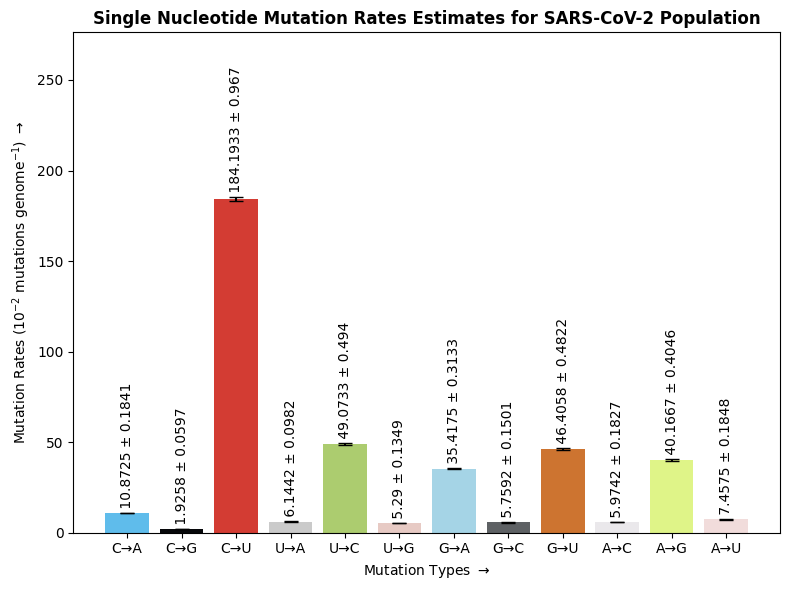

In [ ]:

def plot_single_nucleotide_mutation_rates_estimates(single_nucleotide_mutation_types, single_nucleotide_mutation_rates_mean, single_nucleotide_mutation_rates_margin_of_errors):
    """
    Plot a Bar Plot to Visualize Single-Nucleotide Mutation Rates Estimates for the SARS-CoV-2 Population.

    Parameters:
        - single_nucleotide_mutation_types (list): List of mutation types
        - single_nucleotide_mutation_rates_mean (list): Mean mutation rates for each mutation type.
        - single_nucleotide_mutation_rates_margin_of_errors (list): Margins of error for each mutation rate.
    """
    
    # Factor for scaling up (10**e) the mutation rates values to make them easier to visualize
    e=2

    # Colors for the bars
    colors = ['#5fbceb', '#06070a', '#d33c33', '#cacaca', '#accc6f', '#e7cac4', '#a5d4e6', '#5e6164', '#cd7430', '#eae8eb', '#dff488', '#f1dcdb']

    # Plotting
    plt.figure(figsize=(8, 6))
    #Since it is RNA we replace T with U
    bars = plt.bar([mutation_type.replace("T","U").replace("->", "→") for mutation_type in single_nucleotide_mutation_types], [mean * 10**e for mean in single_nucleotide_mutation_rates_mean], yerr=[error * 10**e for error in single_nucleotide_mutation_rates_margin_of_errors], capsize=5, color=colors[:len(single_nucleotide_mutation_types)])
    # Set Axes labels
    plt.xlabel(r'Mutation Types $\rightarrow$')
    plt.ylabel(rf'Mutation Rates ($10^{{-{e}}}$ mutations genome$^{{-1}}$) $\rightarrow$')
    # Set Plot Title
    plt.title('Single Nucleotide Mutation Rates Estimates for SARS-CoV-2 Population', fontweight='bold')
    # Adjust y-axis limits
    plt.ylim(0, 1.5 * max([mean * 10**e for mean in single_nucleotide_mutation_rates_mean]))  

    # Adding labels above each bar
    for bar, mean, error in zip(bars, single_nucleotide_mutation_rates_mean, single_nucleotide_mutation_rates_margin_of_errors):
        plt.text(
            bar.get_x() + bar.get_width() / 2, bar.get_height() + error* 10**e,  
            f' {round(mean*10**e, 4)} ± {round(error*10**e,4)}', 
            ha='center', va='bottom', fontsize=10, rotation=90
        )
    # Improve layout
    plt.tight_layout()
    # Display the plot
    plt.show()

plot_single_nucleotide_mutation_rates_estimates(single_nucleotide_mutation_types, single_nucleotide_mutation_rates_mean, single_nucleotide_mutation_rates_margin_of_errors)

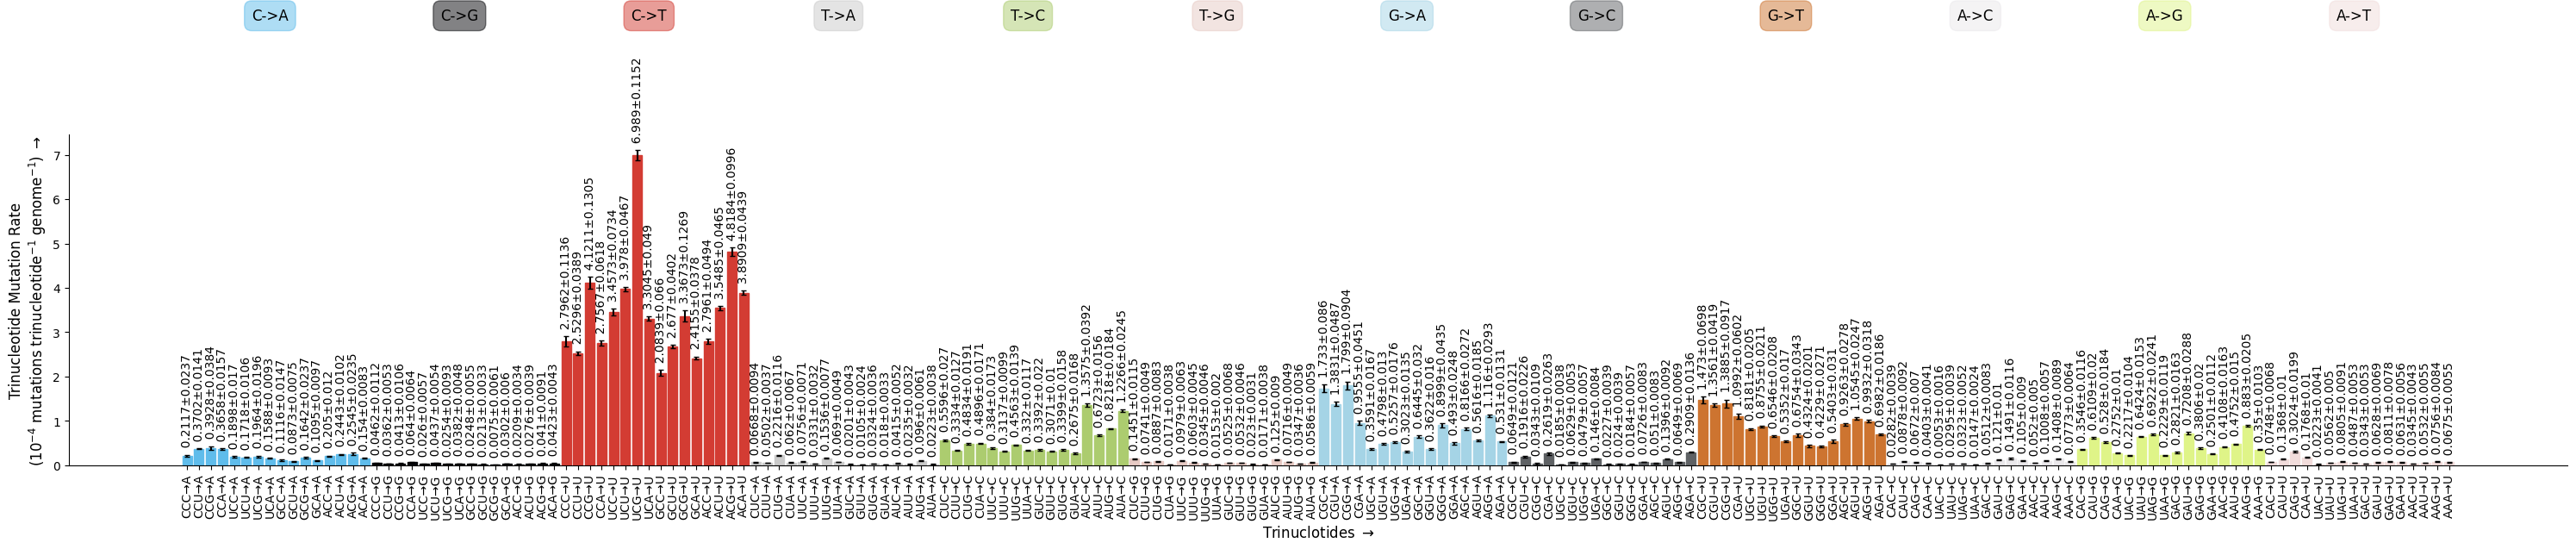

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


def plot_trinucleotide_mutation_rates_estimates(trinucleotide_mutation_types, trinucleotide_mutation_rates_mean, trinucleotide_mutation_rates_margin_of_error):
    """
    Plot to Visualize Trinucleotide Mutation Rates Estimates for all mutation types for the entire SARS-CoV-2 Population.

    Parameters:
        - trinucleotide_mutation_types (list): List of trinucleotide mutation types (e.g., 'ACG→T').
        - trinucleotide_mutation_rates_mean (list): Mean mutation rates for each trinucleotide mutation.
        - trinucleotide_mutation_rates_margin_of_error (list): Margins of error for each mean mutation rate.
    """
    
    # Factor for scaling up (10**e) the trinucleotide mutation rates values to make them easier to visualize
    e=4

    # Prepare subheadings corresponding to each single nucleotide mutation types which relates to the 16 associated trinucleotides
    subheadings = [trinucleotide_mutation_types[i][1]+"->"+trinucleotide_mutation_types[i][-1] for i in range(0, len(trinucleotide_mutation_types), 16)]

    # Color cycle for the bars
    colors = ['#5fbceb', '#06070a', '#d33c33', '#cacaca', '#accc6f', '#e7cac4', '#a5d4e6', '#5e6164', '#cd7430', '#eae8eb', '#dff488', '#f1dcdb']
    color_cycle = [color for color in colors for _ in range(16)]

    # Plotting the bar plot with mutation rates estimates and cycling colors
    plt.figure(figsize=(30, 7))
    for i in range(len(trinucleotide_mutation_types)):
        # Plot the bar
        bars=plt.bar(trinucleotide_mutation_types[i].replace("T","U"), trinucleotide_mutation_rates_mean[i]*10**e, color=color_cycle[i], edgecolor=color_cycle[i]) 

        # Add error bars for confidence intervals
        plt.errorbar(trinucleotide_mutation_types[i].replace("T","U"), trinucleotide_mutation_rates_mean[i]*10**e, yerr=trinucleotide_mutation_rates_margin_of_error[i]*10**e, fmt='none',  capsize=2, color="black")

        # Add subheading at the top middle of every 16 bars
        if (i + 1) % 16 == 8:  # the middle point is the 8th bar in each group
            bbox_props = dict(boxstyle="round,pad=0.5", edgecolor=color_cycle[i], facecolor=color_cycle[i], alpha=0.5)
            plt.text(i, (max(trinucleotide_mutation_rates_mean) + max(trinucleotide_mutation_rates_margin_of_error))*1.4 *10**e, subheadings[int((i + 1) / 16)],
                    ha='center', va='bottom', fontsize=12, color='black', bbox=bbox_props)

        # Add value (i.e. trinucleotide mutation rates) at the top of each bar
        plt.text(i, (trinucleotide_mutation_rates_mean[i] + trinucleotide_mutation_rates_margin_of_error[i])*10**e, "  " + str(round(trinucleotide_mutation_rates_mean[i]*10**e, 4))+ "±"+ str(round(trinucleotide_mutation_rates_margin_of_error[i]*10**e,4)), ha='center', va='bottom', fontsize=10, rotation=90)

    # Plot formatting
    plt.xlabel(r'Trinuclotides $\rightarrow$', fontsize=12)
    plt.ylabel(rf"Trinucleotide Mutation Rate" + "\n"+rf"($10^{{-{e}}}$ mutations trinucleotide$^{{-1}}$ genome$^{{-1}}$) $\rightarrow$", fontsize=12)

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=90, ha='center', fontsize=10)

    # Remove outline at top and right
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()

# Call the function to plot the trinucleotide mutation rate estimates for all the mutation types for the entire SARS-CoV-2 population
plot_trinucleotide_mutation_rates_estimates(trinucleotide_mutation_types, trinucleotide_mutation_rates_mean, trinucleotide_mutation_rates_margin_of_error)

/tmp/ipykernel_148228/883749661.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([f"{polynucleotide} ({str(Seq(polynucleotide).reverse_complement())})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/tmp/ipykernel_148228/883749661.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([f"{str(Seq(polynucleotide).reverse_complement())} ({polynucleotide})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/tmp/ipykernel_148228/883749661.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


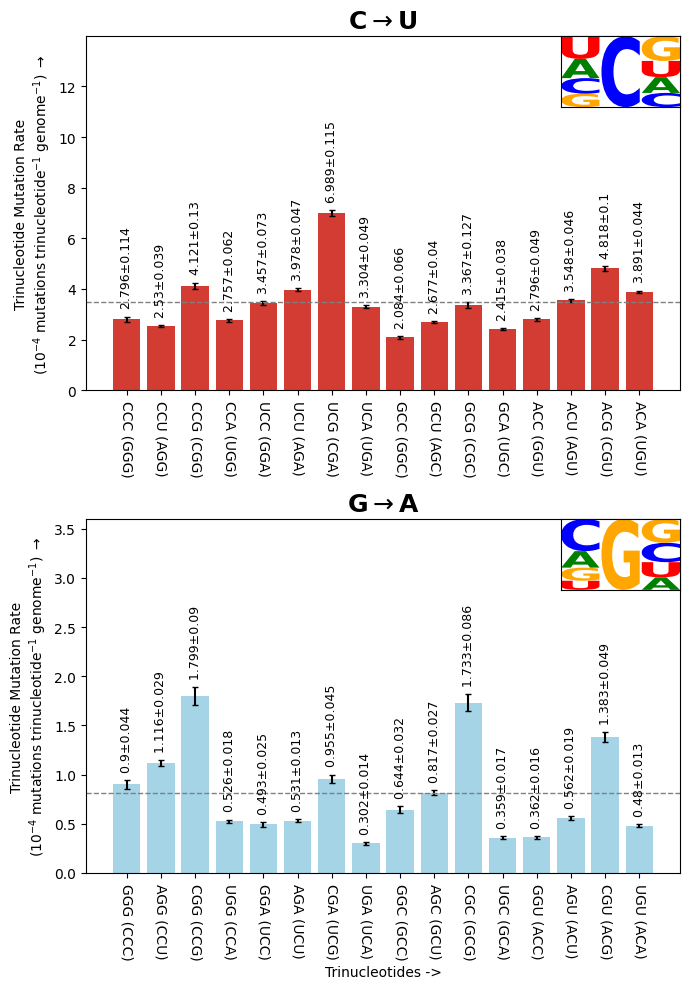

/tmp/ipykernel_148228/883749661.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([f"{polynucleotide} ({str(Seq(polynucleotide).reverse_complement())})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/tmp/ipykernel_148228/883749661.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([f"{str(Seq(polynucleotide).reverse_complement())} ({polynucleotide})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/tmp/ipykernel_148228/883749661.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


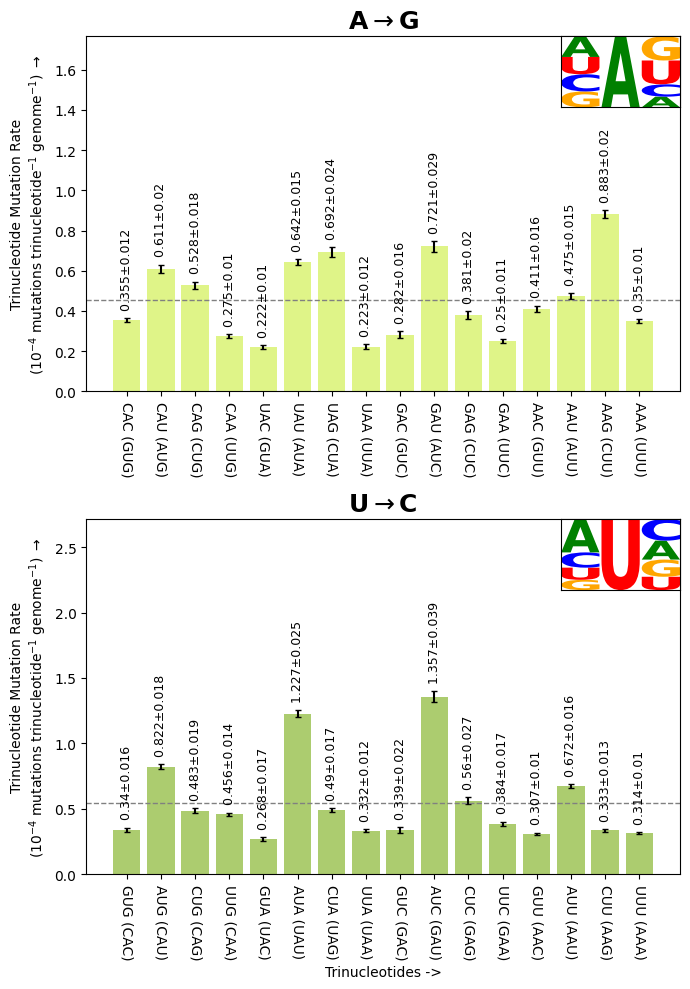

/tmp/ipykernel_148228/883749661.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([f"{polynucleotide} ({str(Seq(polynucleotide).reverse_complement())})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/tmp/ipykernel_148228/883749661.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([f"{str(Seq(polynucleotide).reverse_complement())} ({polynucleotide})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/tmp/ipykernel_148228/883749661.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


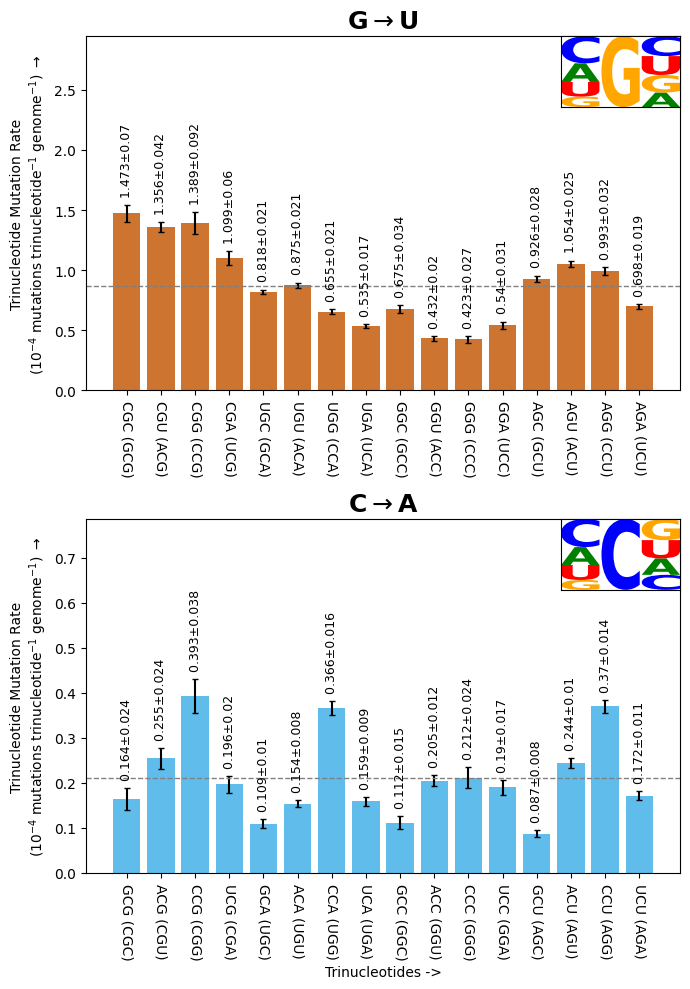

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logomaker
from Bio.Seq import Seq
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_trinucleotide_mutations_for_complementary_mutations(trinucleotide_mutation_types, trinucleotide_mutation_rates_mean, trinucleotide_mutation_rates_margin_of_error, reference_mutation_type, color1, complementary_mutation_type, color2):
    """ 
    Plot trinucleotide mutation rates for reference and complementary mutation types 
    along with the Position Weight Matrix (PWM) computed from trinucleotide mutation rates.
 
    Parameters:
        - trinucleotide_mutation_types (list): List of trinucleotide mutation types (e.g., 'ACG→T').
        - trinucleotide_mutation_rates_mean (list): Mean mutation rates for each trinucleotide mutation.
        - trinucleotide_mutation_rates_margin_of_error (list): Margins of error for each mean mutation rate.
        - reference_mutation_type (str): The reference mutation type.
        - color1 (str): Color for reference mutation type.
        - complementary_mutation_type (str): The complementary mutation type.
        - color2 (str): Color for complementary mutation type.
    """
    
    # Factor for scaling up (10**e) the trinucleotide mutation rates values to make them easier to visualize
    e=4

    fig, ax = plt.subplots(2,1 , figsize=(7, 10))

    # Store the trinucleotide mutation rates for the reference and complementary mutation types in a way that makes it easier to plot
    trinucleotide_mutation_rate_estimates_and_MOE={}
    for index, trinucleotide_mutation_type in enumerate(trinucleotide_mutation_types):
        trinucleotide=trinucleotide_mutation_type.split("→")[0]
        alternate_base=trinucleotide_mutation_type.split("→")[1]
        if(trinucleotide not in trinucleotide_mutation_rate_estimates_and_MOE):
            trinucleotide_mutation_rate_estimates_and_MOE[trinucleotide]={}
            trinucleotide_mutation_rate_estimates_and_MOE[trinucleotide][alternate_base]=[trinucleotide_mutation_rates_mean[index], trinucleotide_mutation_rates_margin_of_error[index]]
        else:
            trinucleotide_mutation_rate_estimates_and_MOE[trinucleotide][alternate_base]=[trinucleotide_mutation_rates_mean[index], trinucleotide_mutation_rates_margin_of_error[index]]

    trinucleotide_mutation_rates = {}
    for trinucleotide in trinucleotide_mutation_rate_estimates_and_MOE:
        if trinucleotide[1] == reference_mutation_type[0]:
            for alt_base in trinucleotide_mutation_rate_estimates_and_MOE[trinucleotide]:
                if alt_base == reference_mutation_type[-1]:
                    trinucleotide_mutation_rates[trinucleotide] = [trinucleotide_mutation_rate_estimates_and_MOE[trinucleotide][alt_base]]
    for trinucleotide in trinucleotide_mutation_rate_estimates_and_MOE:
        if trinucleotide[1] == complementary_mutation_type[0]:
            for alt_base in trinucleotide_mutation_rate_estimates_and_MOE[trinucleotide]:
                if alt_base == complementary_mutation_type[-1]:
                    trinucleotide_mutation_rates[str(Seq(trinucleotide).reverse_complement())].append(trinucleotide_mutation_rate_estimates_and_MOE[trinucleotide][alt_base])

    # Plot the bar plot for the reference mutation type
    bars1 = ax[0].bar(
        [f"{polynucleotide}_{str(Seq(polynucleotide).reverse_complement())}" for polynucleotide in trinucleotide_mutation_rates],
        [trinucleotide_mutation_rates[polynucleotide][0][0]*10**e for polynucleotide in trinucleotide_mutation_rates],
        color=color1)
    
    ax[0].errorbar([f"{polynucleotide}_{str(Seq(polynucleotide).reverse_complement())}" for polynucleotide in trinucleotide_mutation_rates],
                    [trinucleotide_mutation_rates[polynucleotide][0][0]*10**e for polynucleotide in trinucleotide_mutation_rates],
                     yerr=[trinucleotide_mutation_rates[polynucleotide][0][1]*10**e for polynucleotide in trinucleotide_mutation_rates], fmt='none',  capsize=2, color="black")

    ax[0].set_ylabel(rf"Trinucleotide Mutation Rate" + "\n"+rf"($10^{{-{e}}}$ mutations trinucleotide$^{{-1}}$ genome$^{{-1}}$) $\rightarrow$")
    ax[0].set_title(reference_mutation_type.replace("T","U"), fontweight='bold', fontsize=18)
    ax[0].set_ylim(0, 2 * max(trinucleotide_mutation_rates[polynucleotide][0][0]*10**e for polynucleotide in trinucleotide_mutation_rates))
    ax[0].set_xticklabels([f"{polynucleotide} ({str(Seq(polynucleotide).reverse_complement())})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
    
    # Plot the bar plot for the complementary mutation type
    bars2 = ax[1].bar(
        [f"{polynucleotide}_{str(Seq(polynucleotide).reverse_complement())}" for polynucleotide in trinucleotide_mutation_rates],
        [trinucleotide_mutation_rates[polynucleotide][1][0]*10**e for polynucleotide in trinucleotide_mutation_rates],
        color=color2)
    
    ax[1].errorbar([f"{polynucleotide}_{str(Seq(polynucleotide).reverse_complement())}" for polynucleotide in trinucleotide_mutation_rates],
                    [trinucleotide_mutation_rates[polynucleotide][1][0]*10**e for polynucleotide in trinucleotide_mutation_rates],
                     yerr=[trinucleotide_mutation_rates[polynucleotide][1][1]*10**e for polynucleotide in trinucleotide_mutation_rates], fmt='none',  capsize=2, color="black")

    ax[1].set_ylabel(rf"Trinucleotide Mutation Rate" + "\n"+rf"($10^{{-{e}}}$ mutations trinucleotide$^{{-1}}$ genome$^{{-1}}$) $\rightarrow$")
    ax[1].set_title(complementary_mutation_type.replace("T","U"), fontweight='bold', fontsize=18)
    ax[1].set_xlabel('Trinucleotides ->')
    ax[1].set_ylim(0, 2 * max(trinucleotide_mutation_rates[polynucleotide][1][0]*10**e for polynucleotide in trinucleotide_mutation_rates))
    ax[1].set_xticklabels([f"{str(Seq(polynucleotide).reverse_complement())} ({polynucleotide})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)

    # Function to mention the trinucleotide mutatio rates values at the top of each bar
    def add_value_labels(ax, bars, counts, errors):
        for bar, count, error in zip(bars, counts, errors):
            height = bar.get_height() + error*10**e  
            ax.annotate(f' {round(count*10**e,3)}±{round(error*10**e,3)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90, fontsize=9)

    # Add Trinucleotide Mutation rate value with error margin at the top of each bar in both plots
    add_value_labels(
        ax[0], bars1, 
        [trinucleotide_mutation_rates[polynucleotide][0][0] for polynucleotide in trinucleotide_mutation_rates],
        [trinucleotide_mutation_rates[polynucleotide][0][1] for polynucleotide in trinucleotide_mutation_rates]
    )
    add_value_labels(
        ax[1], bars2, 
        [trinucleotide_mutation_rates[polynucleotide][1][0] for polynucleotide in trinucleotide_mutation_rates],
        [trinucleotide_mutation_rates[polynucleotide][1][1] for polynucleotide in trinucleotide_mutation_rates]
    )


    # Add a horizontal line depicting the average trinucleotide mutation rate
    ax[0].axhline(np.mean([bar.get_height() for bar in bars1]), color='grey', linestyle='--', linewidth=1)
    ax[1].axhline(np.mean([bar.get_height() for bar in bars2]), color='grey', linestyle='--', linewidth=1)

    # Compute the PWM for the reference mutation type
    combined_mutation_dict = {
        trinucleotide: trinucleotide_mutation_rate_estimates_and_MOE[trinucleotide][reference_mutation_type[-1]]
        for trinucleotide in trinucleotide_mutation_rate_estimates_and_MOE if trinucleotide[1] == reference_mutation_type[0]
    }
    pwm = np.zeros((3, 4))
    for trinucleotide, rate in combined_mutation_dict.items():
        if rate[0] > 0:
            for i, base in enumerate(trinucleotide):
                if base == "A":
                    pwm[i, 0] += rate[0]
                elif base == "C":
                    pwm[i, 1] += rate[0]
                elif base == "G":
                    pwm[i, 2] += rate[0]
                elif base == "T":
                    pwm[i, 3] += rate[0]
    normalized_pwm = pwm / pwm.sum(axis=1, keepdims=True)
    pwm_df = pd.DataFrame(normalized_pwm, index=[i for i in range(1, 4)], columns=["A", "C", "G", "U"])

    # Add the PWM sub-plot for the reference mutation type
    inset_ax = inset_axes(ax[0], width="20%", height="20%", loc='upper right', borderpad=0)
    logo_reference_strand = logomaker.Logo(pwm_df, ax=inset_ax, shade_below=0.5, fade_below=0.5)
   
    # Remove x and y ticks from the PWM
    logo_reference_strand.ax.set_xticks([])
    logo_reference_strand.ax.set_yticks([])



    # Repeat the same for computing the PWM for the complementary mutation type
    combined_mutation_dict = {
        trinucleotide: trinucleotide_mutation_rate_estimates_and_MOE[trinucleotide][complementary_mutation_type[-1]]
        for trinucleotide in trinucleotide_mutation_rate_estimates_and_MOE if trinucleotide[1] == complementary_mutation_type[0]
    }
    pwm = np.zeros((3, 4))
    for trinucleotide, rate in combined_mutation_dict.items():
        if rate[0] > 0:
            for i, base in enumerate(trinucleotide):
                if base == "A":
                    pwm[i, 0] += rate[0]
                elif base == "C":
                    pwm[i, 1] += rate[0]
                elif base == "G":
                    pwm[i, 2] += rate[0]
                elif base == "T":
                    pwm[i, 3] += rate[0]
    normalized_pwm = pwm / pwm.sum(axis=1, keepdims=True)
    pwm_df = pd.DataFrame(normalized_pwm, index=[i for i in range(1, 4)], columns=["A", "C", "G", "U"])


    # Plot PWM for complementary mutation type
    inset_ax = inset_axes(ax[1], width="20%", height="20%", loc='upper right', borderpad=0)
    logo_opposite_strand = logomaker.Logo(pwm_df, ax=inset_ax, shade_below=0.5, fade_below=0.5)
    
    # Remove x and y ticks from the PWM subplot
    logo_opposite_strand.ax.set_xticks([])
    logo_opposite_strand.ax.set_yticks([])


    plt.tight_layout()
    plt.show()

# Call the function to plot trinucleotide mutation rate estimates for the complementary mutation types
plot_trinucleotide_mutations_for_complementary_mutations(trinucleotide_mutation_types, trinucleotide_mutation_rates_mean, trinucleotide_mutation_rates_margin_of_error,  r"C$\rightarrow$T", '#d33c33', r"G$\rightarrow$A", '#a5d4e6')
plot_trinucleotide_mutations_for_complementary_mutations(trinucleotide_mutation_types, trinucleotide_mutation_rates_mean, trinucleotide_mutation_rates_margin_of_error, r"A$\rightarrow$G", '#dff488', r"T$\rightarrow$C", '#accc6f')
plot_trinucleotide_mutations_for_complementary_mutations(trinucleotide_mutation_types, trinucleotide_mutation_rates_mean, trinucleotide_mutation_rates_margin_of_error, r"G$\rightarrow$T", '#cd7430', r"C$\rightarrow$A", '#5fbceb')